# CSCI 490 - Computer Vision 
# BIOMI 813 - Pattern recognition and machine learning
---
## Deep learning: Practical linear and nonlinear classifier training on MNIST 
## a.k.a. Dr. Perceptron

<img src="img/Dr._Perceptron.jpg",width=520, align=left>

In [1]:
import os
import sys
import time
import struct
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import seaborn as sns
%matplotlib inline

import theano
import theano.tensor as T

import lasagne
import lasagne.layers as L
import lasagne.regularization as R
import lasagne.nonlinearities as NL
import lasagne.objectives as O
import lasagne.init as I

fpX = np.float32
from loadMNIST import LoadMNIST

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

# Procedure:
### Each example follow the simple following procedure:
### 0) Load the input example and target labels.

### 1) Define the network structure.
We are only going to make modifications here. The network itself can be seen as a parametrized function $\bar y = f(x; \theta)$ where $x$ is the input, $\theta$ is the parameters and $\bar y$ is the predicted output. $y$ would be the target associated with $x$ i.e. the actual desired output.

### 2) Compile the gradient expression.
In theano (the machine learning framework used under the hood here), an expression is first created symbolically like a blueprint, then sent to the shop for manufacturing (compilation). Only after compilation do we have expression that we can use (e.g. $\bar y = f(x)$ or $\nabla_\theta E(x, y)$. 

### 3) Perform the parameter optimization (training).
Training is divided into epochs. One epoch means that we go through the whole set of training example once, and for each example we calculate the gradient of the loss with respect to the parameters of the network in order to improve (reduce) the loss. It is customary (though not required) to test the validation accuracy after each epoch of training.

### 4) Validate the newly parametrized network on new input/target pair 
Alternativelly this can be done during training to see how the validation accuracy change over time).

### 5) Look at the results

# Step 0) Load MNIST digits dataset

In [3]:
dataset_folder = '/home/styvesg/Documents/PostDoc/Programs/JupyterNotebooks/DataSet/'

mnist_trn_img = dataset_folder + 'train-images.idx3-ubyte'
mnist_trn_lab = dataset_folder + 'train-labels.idx1-ubyte'
mnist_val_img = dataset_folder + 't10k-images.idx3-ubyte'
mnist_val_lab = dataset_folder + 't10k-labels.idx1-ubyte'

In [4]:
#Note that we reshaped the file into a 4d tensor with dimensions (sample_count, depth=1, x=28, y=28)
mnist_trn_data = LoadMNIST(mnist_trn_img).astype(fpX)[:,np.newaxis,:,:]
mnist_val_data = LoadMNIST(mnist_val_img).astype(fpX)[:,np.newaxis,:,:]
mnist_trn_label = LoadMNIST(mnist_trn_lab)
mnist_val_label = LoadMNIST(mnist_val_lab)

>u1
(60000, 28, 28)
>u1
(10000, 28, 28)
>u1
(60000,)
>u1
(10000,)


In [5]:
trn_size = len(mnist_trn_data)
val_size = len(mnist_val_data)

all_data  = np.concatenate([mnist_trn_data, mnist_val_data], axis=0)
all_label = np.concatenate([mnist_trn_label, mnist_val_label], axis=0)

order = np.arange(len(all_data))
np.random.shuffle(order)
all_data = all_data[order]
all_label = all_label[order]

mnist_trn_data = all_data[:trn_size]
mnist_val_data = all_data[trn_size:]
mnist_trn_label = all_label[:trn_size]
mnist_val_label = all_label[trn_size:]

In [6]:
print mnist_trn_data.shape

(60000, 1, 28, 28)


In [40]:
##normalize images
##note the use of np.newaxis to take advantage of broadcasting rules!
for arr in [mnist_trn_data, mnist_val_data]:
    arr -= np.mean(arr,axis=(2,3))[:,np.newaxis,np.newaxis]  
    arr /= np.sqrt(np.sum(arr**2,axis=(2,3)))[:,np.newaxis,np.newaxis]

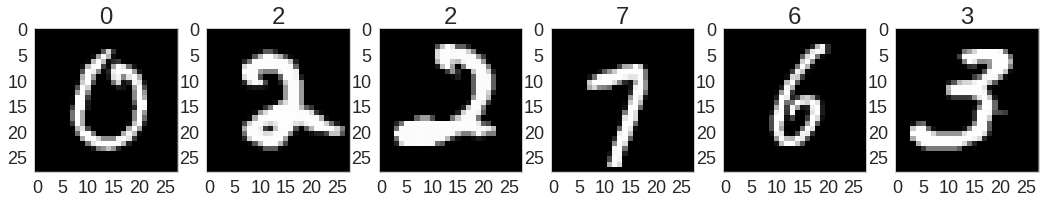

In [41]:
n = 6
plt.figure(figsize=(3*n,3))
for i in range(n):
    plt.subplot(1,n,i+1)
    idx = np.random.randint(0, len(mnist_trn_data))
    plt.imshow(mnist_trn_data[idx,0,:,:], cmap='gray', interpolation='None')
    plt.grid('off')
    plt.title(mnist_trn_label[idx])

### Some helpful functions

In [8]:
def print_lasagne_net(_net, skipnoparam=True):
    '''
    Print a summary of the layer and their parameter shapes
    '''
    layers = L.get_all_layers(_net)
    for l in layers:
        out = l.output_shape
        par = l.get_params()
        if skipnoparam and len(par)==0 and l.name==None:
            continue
        print "Layer\t: %s\nName\t: %s\nType\t: %s" % (l, l.name, type(l))
        print "Shape\t: %s" % (out,)
        if len(par)>0:
            print "Params"
            for p in par:
                print "        |-- {:<10}: {:}".format(p.name, p.get_value().shape,)
        print "\n"

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    '''
    for a given 4d input image tensor and a 2d target tensor of one-hot embedding, 
    return a shuffled batch of input-target pair
    '''
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
          
def embedding(x, c=10): 
    '''
    Also known as one-hot embedding.
    '''
    y = np.zeros((len(x), c), dtype=fpX)
    y[np.arange(len(x)), x] = 1
    return y

# Step 1) Define the classifier net
## Reminder:
The dense layer (fully connected layer) performs $Y = XW + b$ on its (flattened) input $X$ of shape (\# of samples, # of features).

A rectifier nonlinearity, applied after the linear transformation in some cases, is the piece-wise function $\phi(x)=\text{max}(0, x)$ applied element-wise.

A sigmoid nonlinearity, applied after the linear transformation in some cases, is the function $\sigma(x)=\frac{1}{1+\exp(-x)}$ applied element-wise, which outputs number between 0 and 1.

A tanh nonlinearity, applied after the linear transformation in some cases, is the function $tanh(x) = \frac{1-\exp(-2x)}{1+\exp(-2x)}$ applied element-wise, which outputs number between -1 and 1.

In [50]:
npc = 1         # # of channels in image
npx = 28        # # of pixels width/height of images
ny = 10         # # of classes

In [52]:
def model_1(__X):
    '''
    A single linear layer
    '''
    _input = L.InputLayer((None, npc, npx, npx), input_var=__X, name='X')
    _fc1 = L.DenseLayer(_input, ny, W=I.Constant(0.0), b=I.Constant(0.), nonlinearity=None) 
    return _fc1


def model_2(__X): 
    '''
    Multilayer perceptron (rectify nonlinearity) with one nonlinear layer and one final linear classifer layer.
    '''
    _input = L.InputLayer((None, npc, npx, npx), input_var=__X, name='X')
    _fc1 = L.DenseLayer(_input, 4096, W=I.Normal(0.002), b=I.Constant(0.), nonlinearity=NL.rectify)
    _fc2 = L.DenseLayer(_fc1, ny, W=I.Constant(0.0), b=I.Constant(0.), nonlinearity=None)
    return _fc2

In [53]:
_X = T.tensor4() # a theano variable representing the input data
_Y = T.matrix()  # a theano variable representing the class label

_cls = model_2(_X)

# Look at the details of the network input, output and filter shapes
print_lasagne_net(_cls, skipnoparam=True)

cls_params = L.get_all_params(_cls, trainable=True)
print cls_params

Layer	: <lasagne.layers.input.InputLayer object at 0x7f0a30baa890>
Name	: X
Type	: <class 'lasagne.layers.input.InputLayer'>
Shape	: (None, 1, 28, 28)


Layer	: <lasagne.layers.dense.DenseLayer object at 0x7f0a30ca0b50>
Name	: None
Type	: <class 'lasagne.layers.dense.DenseLayer'>
Shape	: (None, 4096)
Params
        |-- W         : (784, 4096)
        |-- b         : (4096,)


Layer	: <lasagne.layers.dense.DenseLayer object at 0x7f0a30ca0e10>
Name	: None
Type	: <class 'lasagne.layers.dense.DenseLayer'>
Shape	: (None, 10)
Params
        |-- W         : (4096, 10)
        |-- b         : (10,)


[W, b, W, b]


# Step 2) Define the loss function and compile the theano expressions

In [54]:
def loss(__y_bar, __y):
    '''The loss function used to train the network -- tells what is good and what is bad'''
    return O.squared_error(__y_bar, __y).mean()

### The following block of code compiles our training expressions. The important part are the functions that results:
cls_trn_fn(X, Y): The classifier training function. It takes a batch of sample data point and labels as input and performs gradient descent on the parameters (all of them!) of our network. It returns the loss and accuracy on that batch.

cls_val_fn(X, Y): The classifier validation function. It takes a batch of sample data point and labels as input and returns the loss and accuracy on that batch.

cls_pred_fn(X): For a batch of sample data point, return the predicted label i.e. the one corresponding to the maximum network output value.

In [55]:
_lr = theano.shared(fpX(0))
_l2 = theano.shared(fpX(0))

_cls_reg = _l2 * R.regularize_layer_params(_cls, R.l2) # regularization loss
_cls_trn_pred = L.get_output(_cls, deterministic=False) # training prediction
_cls_trn_loss = loss(_cls_trn_pred, _Y) + _cls_reg # total training loss
_cls_trn_acc = T.mean(T.eq(T.argmax(_cls_trn_pred, axis=1), T.argmax(_Y, axis=1)), dtype=theano.config.floatX) # validation accuracies

_cls_val_pred = L.get_output(_cls, deterministic=True) #validation prediction
_cls_val_loss = loss(_cls_val_pred, _Y) + _cls_reg # total validation loss
_cls_val_acc = T.mean(T.eq(T.argmax(_cls_val_pred, axis=1), T.argmax(_Y, axis=1)), dtype=theano.config.floatX) # validation accuracies

_class = T.argmax(_cls_val_pred, axis=1)

cls_updates = lasagne.updates.sgd(_cls_trn_loss, cls_params, learning_rate=_lr) 
#cls_updates = lasagne.updates.apply_momentum(cls_updates, cls_params, momentum=0.9)

print 'COMPILING'
t = time.time()
cls_trn_fn = theano.function([_X, _Y], [_cls_trn_loss, _cls_trn_acc], updates=cls_updates)
cls_val_fn = theano.function([_X, _Y], [_cls_val_loss, _cls_val_acc])
cls_pred_fn = theano.function([_X], _class)
print '%.2f seconds to compile theano functions'%(time.time()-t)

COMPILING
1.00 seconds to compile theano functions


# Step 3 & 4) Training and validating the model. 

-Note that the parameter initialization, which is very important for training success, was defined when we defined the network and the values were initialized at compilation time.

-We decrease learning rate by 'perc_decay'% every epoch after 'niter' epoch at initial rate 'lr'. This is to "fine tune" the learning process toward the end, and is known as learning rate decay.

-We record the history of the training and validation accuracies.

In [56]:
lr = 1.   # initial learning rate for sgd
l2 = 0.    # l2 weight decay
niter = 50        # # of iter at starting learning rate
perc_decay = 5.0 # # of iter to linearly decay learning rate to zero
num_epochs = 50
batch_size = 500
max_trn_size = 60000

_lr.set_value(fpX(lr))
_l2.set_value(fpX(l2))

mnist_trn_emb_label = embedding(mnist_trn_label, ny)
mnist_val_emb_label = embedding(mnist_val_label, ny)

trn_hist = []
val_hist = []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    trn_err = 0
    trn_acc = 0
    trn_batches = 0
    start_time = time.time()
    for xb, yb in tqdm(iterate_minibatches(mnist_trn_data[:max_trn_size], mnist_trn_emb_label[:max_trn_size], batch_size, shuffle=True)):
        _, _ = cls_trn_fn(xb, yb)
    
    for xb, yb in iterate_minibatches(mnist_trn_data[:max_trn_size], mnist_trn_emb_label[:max_trn_size], batch_size, shuffle=False):
        err, acc = cls_val_fn(xb, yb)
        trn_err += err
        trn_acc += acc
        trn_batches += 1
    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for xb, yb in iterate_minibatches(mnist_val_data, mnist_val_emb_label, batch_size, shuffle=False):
        err, acc = cls_val_fn(xb, yb)
        val_err += err
        val_acc += acc
        val_batches += 1

    trn_hist += [trn_acc / trn_batches,]
    val_hist += [val_acc / val_batches,]
    # Then we print the results for this epoch:
    print("\n  Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:       {:.6f}".format(trn_err / trn_batches))
    print("  training accuracy:   {:.2f} %".format(trn_acc / trn_batches * 100))
    print("  validation loss:     {:.6f}".format(val_err / val_batches))
    print("  validation accuracy: {:.2f} %".format(val_acc / val_batches * 100))
    
    if epoch > niter:
        _lr.set_value(fpX(_lr.get_value() * (1.0 - perc_decay / 100.0)))     
    sys.stdout.flush()

120it [00:00, 132.70it/s]


  Epoch 1 of 50 took 1.365s
  training loss:       0.038437
  training accuracy:   83.34 %
  validation loss:     0.038315
  validation accuracy: 83.16 %



120it [00:00, 139.85it/s]


  Epoch 2 of 50 took 1.306s
  training loss:       0.021661
  training accuracy:   90.37 %
  validation loss:     0.021880
  validation accuracy: 90.32 %



120it [00:00, 146.21it/s]


  Epoch 3 of 50 took 1.303s
  training loss:       0.018263
  training accuracy:   91.97 %
  validation loss:     0.018533
  validation accuracy: 91.83 %



120it [00:00, 148.66it/s]


  Epoch 4 of 50 took 1.302s
  training loss:       0.016105
  training accuracy:   93.17 %
  validation loss:     0.016374
  validation accuracy: 93.03 %



120it [00:00, 148.01it/s]


  Epoch 5 of 50 took 1.293s
  training loss:       0.014702
  training accuracy:   93.96 %
  validation loss:     0.015047
  validation accuracy: 93.81 %



120it [00:00, 139.55it/s]


  Epoch 6 of 50 took 1.301s
  training loss:       0.013524
  training accuracy:   94.63 %
  validation loss:     0.013924
  validation accuracy: 94.50 %



120it [00:00, 145.86it/s]


  Epoch 7 of 50 took 1.319s
  training loss:       0.012683
  training accuracy:   95.15 %
  validation loss:     0.013123
  validation accuracy: 95.00 %



120it [00:00, 146.61it/s]


  Epoch 8 of 50 took 1.251s
  training loss:       0.011933
  training accuracy:   95.56 %
  validation loss:     0.012438
  validation accuracy: 95.36 %



120it [00:00, 141.16it/s]


  Epoch 9 of 50 took 1.296s
  training loss:       0.011371
  training accuracy:   95.89 %
  validation loss:     0.011932
  validation accuracy: 95.60 %



120it [00:00, 152.57it/s]


  Epoch 10 of 50 took 1.236s
  training loss:       0.010772
  training accuracy:   96.25 %
  validation loss:     0.011367
  validation accuracy: 95.89 %



120it [00:00, 145.91it/s]


  Epoch 11 of 50 took 1.280s
  training loss:       0.010223
  training accuracy:   96.60 %
  validation loss:     0.010869
  validation accuracy: 96.16 %



120it [00:00, 154.30it/s]


  Epoch 12 of 50 took 1.263s
  training loss:       0.009982
  training accuracy:   96.72 %
  validation loss:     0.010673
  validation accuracy: 96.30 %



120it [00:00, 149.73it/s]


  Epoch 13 of 50 took 1.240s
  training loss:       0.009418
  training accuracy:   97.00 %
  validation loss:     0.010131
  validation accuracy: 96.51 %



120it [00:00, 153.13it/s]


  Epoch 14 of 50 took 1.217s
  training loss:       0.009298
  training accuracy:   97.08 %
  validation loss:     0.010046
  validation accuracy: 96.49 %



120it [00:00, 152.23it/s]


  Epoch 15 of 50 took 1.230s
  training loss:       0.008742
  training accuracy:   97.32 %
  validation loss:     0.009542
  validation accuracy: 96.72 %



120it [00:00, 145.37it/s]


  Epoch 16 of 50 took 1.303s
  training loss:       0.008486
  training accuracy:   97.50 %
  validation loss:     0.009307
  validation accuracy: 96.83 %



120it [00:00, 153.52it/s]


  Epoch 17 of 50 took 1.212s
  training loss:       0.008332
  training accuracy:   97.54 %
  validation loss:     0.009228
  validation accuracy: 96.95 %



120it [00:00, 153.54it/s]


  Epoch 18 of 50 took 1.215s
  training loss:       0.007969
  training accuracy:   97.71 %
  validation loss:     0.008881
  validation accuracy: 97.03 %



120it [00:00, 144.68it/s]


  Epoch 19 of 50 took 1.276s
  training loss:       0.007786
  training accuracy:   97.78 %
  validation loss:     0.008743
  validation accuracy: 97.06 %



120it [00:00, 139.53it/s]


  Epoch 20 of 50 took 1.319s
  training loss:       0.007623
  training accuracy:   97.87 %
  validation loss:     0.008586
  validation accuracy: 97.12 %



120it [00:00, 156.65it/s]


  Epoch 21 of 50 took 1.273s
  training loss:       0.007358
  training accuracy:   97.96 %
  validation loss:     0.008389
  validation accuracy: 97.21 %



120it [00:00, 148.22it/s]


  Epoch 22 of 50 took 1.244s
  training loss:       0.007264
  training accuracy:   98.02 %
  validation loss:     0.008276
  validation accuracy: 97.28 %



120it [00:00, 153.60it/s]


  Epoch 23 of 50 took 1.213s
  training loss:       0.006984
  training accuracy:   98.09 %
  validation loss:     0.008069
  validation accuracy: 97.39 %



120it [00:00, 144.46it/s]


  Epoch 24 of 50 took 1.278s
  training loss:       0.006783
  training accuracy:   98.16 %
  validation loss:     0.007887
  validation accuracy: 97.45 %



120it [00:00, 157.40it/s]


  Epoch 25 of 50 took 1.211s
  training loss:       0.006645
  training accuracy:   98.22 %
  validation loss:     0.007795
  validation accuracy: 97.46 %



120it [00:00, 157.57it/s]


  Epoch 26 of 50 took 1.208s
  training loss:       0.006547
  training accuracy:   98.27 %
  validation loss:     0.007734
  validation accuracy: 97.47 %



120it [00:00, 154.15it/s]


  Epoch 27 of 50 took 1.209s
  training loss:       0.006340
  training accuracy:   98.35 %
  validation loss:     0.007550
  validation accuracy: 97.51 %



120it [00:00, 154.32it/s]


  Epoch 28 of 50 took 1.208s
  training loss:       0.006221
  training accuracy:   98.37 %
  validation loss:     0.007455
  validation accuracy: 97.55 %



120it [00:00, 154.00it/s]


  Epoch 29 of 50 took 1.210s
  training loss:       0.006125
  training accuracy:   98.41 %
  validation loss:     0.007382
  validation accuracy: 97.64 %



120it [00:00, 154.26it/s]


  Epoch 30 of 50 took 1.225s
  training loss:       0.005969
  training accuracy:   98.48 %
  validation loss:     0.007262
  validation accuracy: 97.66 %



120it [00:00, 152.83it/s]


  Epoch 31 of 50 took 1.292s
  training loss:       0.005898
  training accuracy:   98.54 %
  validation loss:     0.007221
  validation accuracy: 97.82 %



120it [00:00, 142.60it/s]


  Epoch 32 of 50 took 1.296s
  training loss:       0.005734
  training accuracy:   98.54 %
  validation loss:     0.007072
  validation accuracy: 97.77 %



120it [00:00, 150.76it/s]


  Epoch 33 of 50 took 1.228s
  training loss:       0.005616
  training accuracy:   98.60 %
  validation loss:     0.006966
  validation accuracy: 97.82 %



120it [00:00, 147.55it/s]


  Epoch 34 of 50 took 1.311s
  training loss:       0.005509
  training accuracy:   98.66 %
  validation loss:     0.006902
  validation accuracy: 97.80 %



120it [00:00, 146.67it/s]


  Epoch 35 of 50 took 1.282s
  training loss:       0.005445
  training accuracy:   98.69 %
  validation loss:     0.006889
  validation accuracy: 97.89 %



120it [00:00, 151.22it/s]


  Epoch 36 of 50 took 1.287s
  training loss:       0.005389
  training accuracy:   98.68 %
  validation loss:     0.006841
  validation accuracy: 97.86 %



120it [00:00, 139.38it/s]


  Epoch 37 of 50 took 1.313s
  training loss:       0.005256
  training accuracy:   98.75 %
  validation loss:     0.006734
  validation accuracy: 97.89 %



120it [00:00, 142.91it/s]


  Epoch 38 of 50 took 1.298s
  training loss:       0.005244
  training accuracy:   98.79 %
  validation loss:     0.006724
  validation accuracy: 97.89 %



120it [00:00, 157.44it/s]


  Epoch 39 of 50 took 1.240s
  training loss:       0.005030
  training accuracy:   98.82 %
  validation loss:     0.006558
  validation accuracy: 97.99 %



120it [00:00, 146.71it/s]


  Epoch 40 of 50 took 1.257s
  training loss:       0.004992
  training accuracy:   98.83 %
  validation loss:     0.006551
  validation accuracy: 97.92 %



120it [00:00, 140.61it/s]


  Epoch 41 of 50 took 1.297s
  training loss:       0.004874
  training accuracy:   98.86 %
  validation loss:     0.006432
  validation accuracy: 97.97 %



120it [00:00, 142.12it/s]


  Epoch 42 of 50 took 1.294s
  training loss:       0.004823
  training accuracy:   98.88 %
  validation loss:     0.006418
  validation accuracy: 97.97 %



120it [00:00, 156.85it/s]


  Epoch 43 of 50 took 1.217s
  training loss:       0.004753
  training accuracy:   98.88 %
  validation loss:     0.006365
  validation accuracy: 97.94 %



120it [00:00, 149.88it/s]


  Epoch 44 of 50 took 1.240s
  training loss:       0.004639
  training accuracy:   98.98 %
  validation loss:     0.006294
  validation accuracy: 98.03 %



120it [00:00, 151.47it/s]


  Epoch 45 of 50 took 1.230s
  training loss:       0.004654
  training accuracy:   98.97 %
  validation loss:     0.006319
  validation accuracy: 98.05 %



120it [00:00, 151.88it/s]


  Epoch 46 of 50 took 1.227s
  training loss:       0.004510
  training accuracy:   99.01 %
  validation loss:     0.006193
  validation accuracy: 98.06 %



120it [00:00, 153.63it/s]


  Epoch 47 of 50 took 1.230s
  training loss:       0.004455
  training accuracy:   99.04 %
  validation loss:     0.006160
  validation accuracy: 98.11 %



120it [00:00, 157.45it/s]


  Epoch 48 of 50 took 1.210s
  training loss:       0.004514
  training accuracy:   99.06 %
  validation loss:     0.006258
  validation accuracy: 98.10 %



120it [00:00, 153.26it/s]


  Epoch 49 of 50 took 1.215s
  training loss:       0.004335
  training accuracy:   99.14 %
  validation loss:     0.006074
  validation accuracy: 98.15 %



120it [00:00, 151.29it/s]


  Epoch 50 of 50 took 1.227s
  training loss:       0.004221
  training accuracy:   99.14 %
  validation loss:     0.006009
  validation accuracy: 98.12 %


## Plot the history of training and validation accuracies

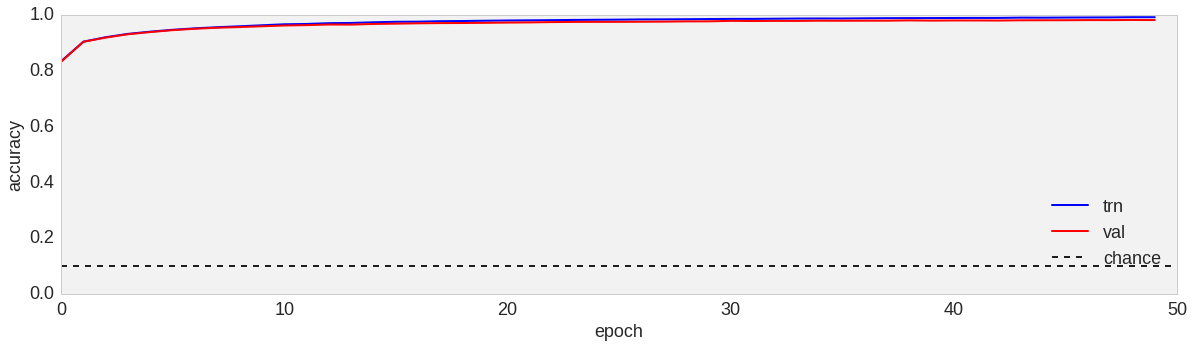

In [57]:
plt.figure(figsize=(20,5))
plt.plot(trn_hist, 'b', label='trn', lw=2)
plt.plot(val_hist, 'r', label='val', lw=2)
plt.axhline(1./ny, color='k', linestyle='--', label='chance')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0., 1.0)
plt.legend(bbox_to_anchor=(1., 0.4))
plt.grid()

## What to do if training fails?
### Right now, we are doing training without most of the modern bells and whistles like momentum, dropout and other learning algorithms based on gradient descent that are more suitable for the problems at hand. But even with the basic toolbox, there is quite a lot we can do when training initially fails:
1) Try different values of the learning rate: sometimes a value too low is as bad as a value that is too high

2) Try changing the initial conditions. Sometimes its better to start at zero but certain nonlinearity will return singular results at this point, so it's not always an option.

3) Try to change the batch size. The batch size adds some randomness to the gradient evaluation. A gradient that is close to zero in one batch may be large in another. However, if the batch size is too large it "evens out" the gradient which means it may be stuck for good for all batch in a local minimum. However, batches too small incur a cost in effectiveness of the algorithm and may not work well with more modern technique like batch-normalization.

4) Play with the architecture.

5) Detect failure early. This is why it is important to monitor the output of the network. One can ususally tell very quickly if things are working or not.

6) Try adding momentum to the gradient descent if the validation accuracy seems stuck at a low value.

## Get the learned parameter values

In [156]:
# get the parameter values into numpy array
W, b = [p.get_value() for p in cls_params]
print W.shape

(64, 1, 7, 7)


## Show an example case of the confusion matrix. What digits are most likely to be confused? Show some instance of this confusion.

In [60]:
C = np.ndarray(shape=(ny,ny))

for xb, yb in iterate_minibatches(mnist_val_data, mnist_val_label, batch_size, shuffle=False):
    ypb  = cls_pred_fn(xb)
    yeb  = embedding(yb, ny)
    yebp = embedding(ypb, ny)

    C += np.dot(yeb.T, yebp)

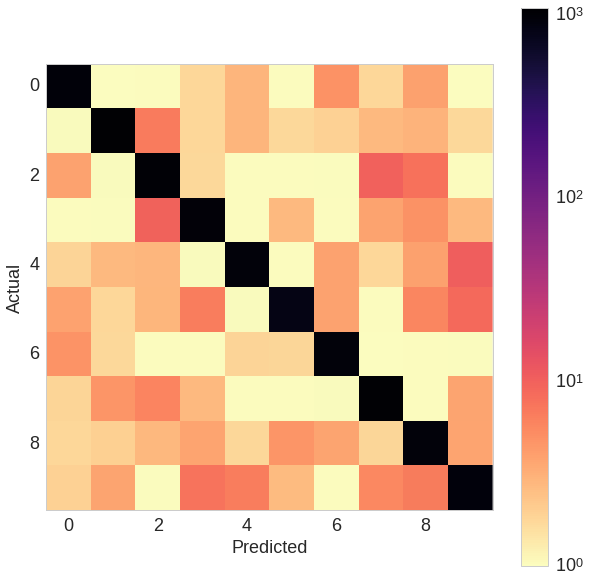

In [61]:
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(10,10))
plt.imshow(C, cmap=cm.magma_r, norm=LogNorm(vmin=1, vmax=np.amax(C)), interpolation='None')
plt.colorbar()
plt.grid('off')
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [62]:
print "Overall classification accuracy = %.1f%%" % (np.trace(C, dtype=fpX) * 100. / len(mnist_val_data))

Overall classification accuracy = 98.2%
